In [1]:
# Install Kaggle API for download competition data
!pip3 install -q kaggle

In [2]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 89kB/s 


In [3]:
# Imports

import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile
import pydicom as dicom
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import backend as K 
K.set_image_data_format('channels_last')

In [4]:
!wget http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip

--2020-06-26 14:44:23--  http://download.cs.stanford.edu/deep/CheXpert-v1.0-small.zip
Resolving download.cs.stanford.edu (download.cs.stanford.edu)... 171.64.64.22
Connecting to download.cs.stanford.edu (download.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11557753157 (11G) [application/zip]
Saving to: ‘CheXpert-v1.0-small.zip’

CheXpert-v1.0-small 100%[===================>]  10.76G  2.04MB/s    in 91m 31s 

2020-06-26 16:15:55 (2.01 MB/s) - ‘CheXpert-v1.0-small.zip’ saved [11557753157/11557753157]



In [5]:
!unzip CheXpert-v1.0-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: CheXpert-v1.0-small/train/patient21643/study3/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient21643/study1/
  inflating: CheXpert-v1.0-small/train/patient21643/study1/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient21643/study2/
  inflating: CheXpert-v1.0-small/train/patient21643/study2/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient63218/
   creating: CheXpert-v1.0-small/train/patient63218/study1/
  inflating: CheXpert-v1.0-small/train/patient63218/study1/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient08046/
   creating: CheXpert-v1.0-small/train/patient08046/study1/
  inflating: CheXpert-v1.0-small/train/patient08046/study1/view1_frontal.jpg  
   creating: CheXpert-v1.0-small/train/patient08046/study5/
  inflating: CheXpert-v1.0-small/train/patient08046/study5/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient08046/study5/vi

## Data

### Kaggle rsna

In [6]:
# download your Kaggle json on your account page on Kaggle

kjson = pd.read_json('kaggle.json',typ='series')

In [7]:
# enter your Kaggle credentionals here

os.environ['KAGGLE_USERNAME']= "matheuscoradini"
os.environ['KAGGLE_KEY']= kjson.key

In [8]:
!kaggle datasets download --force tawsifurrahman/covid19-radiography-database

 98% 1.13G/1.15G [00:34<00:00, 27.2MB/s]
100% 1.15G/1.15G [00:34<00:00, 36.1MB/s]


In [9]:
!kaggle datasets download --force raddar/tuberculosis-chest-xrays-shenzhen

100% 3.51G/3.51G [01:43<00:00, 57.3MB/s]
100% 3.51G/3.51G [01:43<00:00, 36.4MB/s]


In [10]:
!unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
  inflating: COVID-19 Radiography Database/COVID-19.metadata.xlsx  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (1).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (10).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (100).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (101).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (102).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (103).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (104).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (105).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (106).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (107).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (108).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (109).png  
  inflating: COV

In [11]:
!unzip tuberculosis-chest-xrays-shenzhen.zip

Archive:  tuberculosis-chest-xrays-shenzhen.zip
  inflating: images/images/CHNCXR_0001_0.png  
  inflating: images/images/CHNCXR_0002_0.png  
  inflating: images/images/CHNCXR_0003_0.png  
  inflating: images/images/CHNCXR_0004_0.png  
  inflating: images/images/CHNCXR_0005_0.png  
  inflating: images/images/CHNCXR_0006_0.png  
  inflating: images/images/CHNCXR_0007_0.png  
  inflating: images/images/CHNCXR_0008_0.png  
  inflating: images/images/CHNCXR_0009_0.png  
  inflating: images/images/CHNCXR_0010_0.png  
  inflating: images/images/CHNCXR_0011_0.png  
  inflating: images/images/CHNCXR_0012_0.png  
  inflating: images/images/CHNCXR_0013_0.png  
  inflating: images/images/CHNCXR_0014_0.png  
  inflating: images/images/CHNCXR_0015_0.png  
  inflating: images/images/CHNCXR_0016_0.png  
  inflating: images/images/CHNCXR_0017_0.png  
  inflating: images/images/CHNCXR_0018_0.png  
  inflating: images/images/CHNCXR_0019_0.png  
  inflating: images/images/CHNCXR_0020_0.png  
  inflating:

# Metadata

In [12]:
meta_tub = pd.read_csv('shenzhen_metadata.csv')

In [13]:
meta_tub.head()

,study_id,sex,age,findings
0,CHNCXR_0001_0.png,Male,45,normal
1,CHNCXR_0002_0.png,Male,63,normal
2,CHNCXR_0003_0.png,Female,48,normal
3,CHNCXR_0004_0.png,Male,58,normal
4,CHNCXR_0005_0.png,Male,28,normal


In [14]:
meta_tub.findings.value_counts().head(20)

normal                                         326
bilateral PTB                                   61
Right PTB                                       45
PTB in the right upper field                    27
left PTB                                        19
PTB in the left upper field                     19
STB                                             19
Bilateral secondary PTB                         16
secondary PTB  in the right upper field         12
right secondary PTB                             10
PTB in the bilateral upper field                 8
secondary PTB  in the left upper field           8
right upper PTB                                  6
secondary PTB  in the bilateral upper field      6
PTB in the right lower field                     4
PTB  in the right upper field                    3
PTB in the left lower field                      3
PTB in the bilateral upper fields                3
left secondary PTB                               3
PTB                            

In [15]:
meta_tub.loc[meta_tub['findings'] == 'normal', 'findings'] = 1
meta_tub.loc[meta_tub['findings'] != 1, 'findings'] = 3

In [16]:
meta_tub.findings.value_counts()

3    336
1    326
Name: findings, dtype: int64

In [17]:
y_tub = meta_tub.findings

## Image dir

In [18]:
os.listdir('COVID-19 Radiography Database/')

['COVID-19',
 'Viral Pneumonia',
 'NORMAL',
 'Viral Pneumonia.matadata.xlsx',
 'COVID-19.metadata.xlsx',
 'NORMAL.metadata.xlsx',
 'README.md.txt']

In [19]:
imagens_normal = 'COVID-19 Radiography Database/NORMAL'
imagens_covid = 'COVID-19 Radiography Database/COVID-19'
imagens_pneu = 'COVID-19 Radiography Database/Viral Pneumonia'
imagens_sh = 'images/images'
imagens_xpert_train = 'CheXpert-v1.0-small/train'
imagens_xpert_valid = 'CheXpert-v1.0-small/valid'

In [20]:
print(len(os.listdir(imagens_normal)))

1341


In [21]:
print(len(os.listdir(imagens_covid)))

219


In [22]:
print(len(os.listdir(imagens_pneu)))

1345


In [23]:
covid_image_list = os.listdir(imagens_normal)
normal_image_list = os.listdir(imagens_covid)
pneu_image_list = os.listdir(imagens_pneu)
sh_image_list = os.listdir(imagens_sh)
xpert_train_list = os.listdir(imagens_xpert_train)
xpert_test_list = os.listdir(imagens_xpert_valid)

# Stanford CheXpert

In [24]:
train = pd.read_csv('CheXpert-v1.0-small/train.csv')
valid = pd.read_csv('CheXpert-v1.0-small/valid.csv')

In [25]:
train = train[train['Frontal/Lateral'] == 'Frontal']
valid = valid[valid['Frontal/Lateral'] == 'Frontal']

In [26]:
train['Patient'] = train.Path.apply(lambda x: x[:38])
valid['Patient'] = valid.Path.apply(lambda x: x[:38])

In [27]:
train = train.drop_duplicates(subset='Patient')
valid = valid.drop_duplicates(subset='Patient')

In [28]:
train.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,CheXpert-v1.0-small/train/patient00001
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,CheXpert-v1.0-small/train/patient00002
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,CheXpert-v1.0-small/train/patient00003
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,CheXpert-v1.0-small/train/patient00004
7,CheXpert-v1.0-small/train/patient00005/study1/...,Male,33,Frontal,PA,1.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,1.0,CheXpert-v1.0-small/train/patient00005


In [29]:
for i in train.columns:
  train = train[train[i] != -1]

In [30]:
train_normal = train[train['No Finding'] == 1]

# Preparing features

In [31]:
paths = []
y = []

for dirname, _, filenames in os.walk('COVID-19 Radiography Database/Viral Pneumonia'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(0)
            
for dirname, _, filenames in os.walk('COVID-19 Radiography Database/NORMAL'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(1)   

for dirname, _, filenames in os.walk('COVID-19 Radiography Database/COVID-19'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(2)

for dirname, _, filenames in os.walk(imagens_sh):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
y_tub = list(y_tub)
y.extend(y_tub)

for path in train_normal.Path:
    paths.append(path)
    y.append(1)

In [32]:
len(paths)

13575

In [33]:
len(y)

13575

In [34]:
X = []
for i in paths:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (75, 75))

    X.append(image)

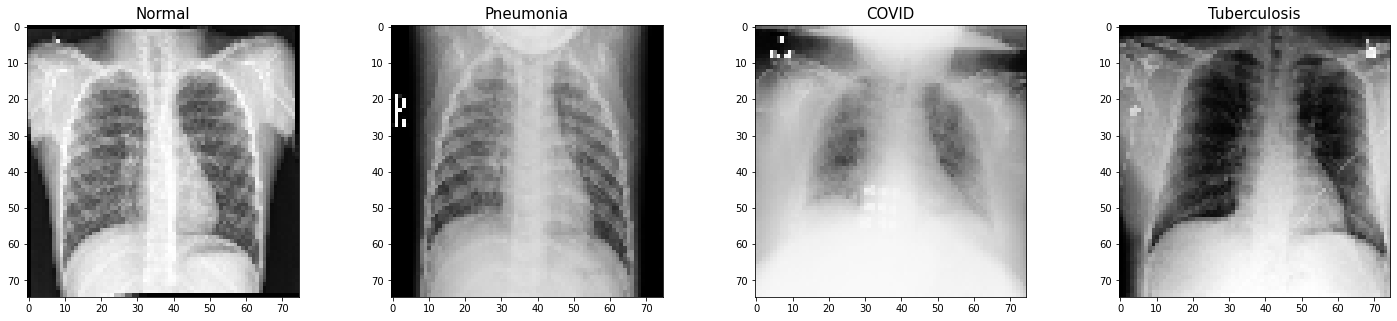

In [35]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(ncols = 4,nrows = 1, figsize = (25,5))
ax1.imshow(X[1500],cmap='gray')
ax2.imshow(X[0],cmap='gray')
ax3.imshow(X[2900],cmap='gray')
ax4.imshow(X[4000],cmap='gray')

ax1.set_title('Normal',fontsize=15)
ax2.set_title('Pneumonia',fontsize=15)
ax3.set_title('COVID',fontsize=15)
ax4.set_title('Tuberculosis',fontsize=15)

plt.show()

# Normalizing and reshaping

In [36]:
X = np.array(X)/255
y = np.array(y)

In [37]:
X.shape

(13575, 75, 75, 3)

# Train Test Split

In [38]:
Xtrain, Xval, ytrain, yval  = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [39]:
Xtrain.shape

(9095, 75, 75, 3)

In [40]:
ycat_val = to_categorical(yval,4)
ycat_train = to_categorical(ytrain,4)

In [41]:
ycat_val.shape

(4480, 4)

# Model

In [42]:
modelo_base = InceptionV3(weights='imagenet', include_top= False, input_shape=(75,75,3))

87916544/87910968 [==============================] - 5s 0us/step


In [43]:
modelo_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [44]:
num_classes=4

In [45]:
# Cria a sequência de camadas
add_model = Sequential()

# Adiciona primeiro o modelo base
add_model.add(modelo_base)

# Precisamos de uma camada global de Pooling
add_model.add(GlobalAveragePooling2D())

# Dropout para regularização e evitar overfitting
add_model.add(Dropout(0.5))

# Camada densa na camada final com ativação softmax para previsão das probabilidades das classes
add_model.add(Dense(num_classes, activation = 'softmax'))

In [46]:
add_model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [47]:
# Regra para a redução da taxa de aprendizado
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [48]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
image_gen.fit(Xtrain)

In [49]:
cw = {0: 1, 1: 1, 2:2, 3:1}
BS = 32

results = add_model.fit_generator(image_gen.flow(Xtrain, ycat_train, batch_size=BS),steps_per_epoch=len(Xtrain)/BS, epochs=60,validation_data=(Xval,ycat_val), callbacks = [reduce_lr], class_weight=cw)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
285/284 [==============================] - 24s 85ms/step - loss: 0.3318 - accuracy: 0.9098 - val_loss: 34.9708 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 2/60
285/284 [==============================] - 22s 76ms/step - loss: 0.2691 - accuracy: 0.9346 - val_loss: 0.5487 - val_accuracy: 0.9020 - lr: 0.0010
Epoch 3/60
285/284 [==============================] - 22s 77ms/step - loss: 0.3725 - accuracy: 0.9097 - val_loss: 34813.7461 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 4/60
285/284 [==============================] - 21s 74ms/step - loss: 0.2826 - accuracy: 0.9207 - val_loss: 0.1698 - val_accuracy: 0.9442 - lr: 0.0010
Epoch 5/60
285/284 [==============================] - 22s 75ms/step - loss: 0.2726 - accuracy: 0.9302 - val_loss: 0.2455 - val_accuracy: 0.9179 - lr: 0.0010
Epoch 6/60
285/284 [==============================] - 22s 77ms/step - loss: 0.3725 - accuracy: 0.9139 - val_loss: 5.1326 - val_accurac

In [50]:
add_model.metrics_names

['loss', 'accuracy']

In [51]:
losses = pd.DataFrame(add_model.history.history)

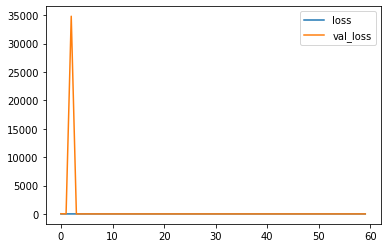

In [52]:
losses[['loss','val_loss']].plot()
plt.show()

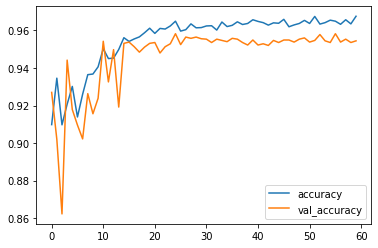

In [53]:
losses[['accuracy','val_accuracy']].plot()
plt.show()

In [54]:
pred = add_model.predict_classes(Xval)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [55]:
# 0: Pneumonia
# 1: Normal
# 2: COVID-19
# 3: Tuberculosis

from sklearn.metrics import classification_report
print(classification_report(yval, pred))

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       437
           1       0.97      0.97      0.97      3861
           2       0.98      0.84      0.91        64
           3       0.49      0.77      0.60       118

    accuracy                           0.95      4480
   macro avg       0.86      0.86      0.85      4480
weighted avg       0.96      0.95      0.96      4480



In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yval, pred)

array([[ 370,   66,    1,    0],
       [   6, 3761,    0,   94],
       [   0,    9,   54,    1],
       [   0,   27,    0,   91]])